# Imports and installations

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import umap
from xgboost import XGBRegressor
from xgboost import cv, DMatrix
from catboost import CatBoostRegressor
from scipy.stats import norm
import lightgbm as lgb
import seaborn as sns
from math import sqrt
import xgboost as xgb
import catboost
from sklearn.ensemble import GradientBoostingRegressor


In [0]:
data_insurance = pd.read_csv('/content/drive/My Drive/EG task/insurance.csv')
data_insurance_const = pd.read_csv('/content/drive/My Drive/EG task/insurance.csv')

In [0]:
results = pd.DataFrame()
mae = np.array([], dtype=np.float64)
mse = np.array([], dtype=np.float64)
rmse = np.array([], dtype=np.float64)
r2 = np.array([], dtype=np.float64)

In [0]:
indx = np.array([], dtype=np.string_)

# Data

## Some analis

Для начала посмотрим на данные и проведем их краткий анализ.

Размерность данных *(1338, 7)*.



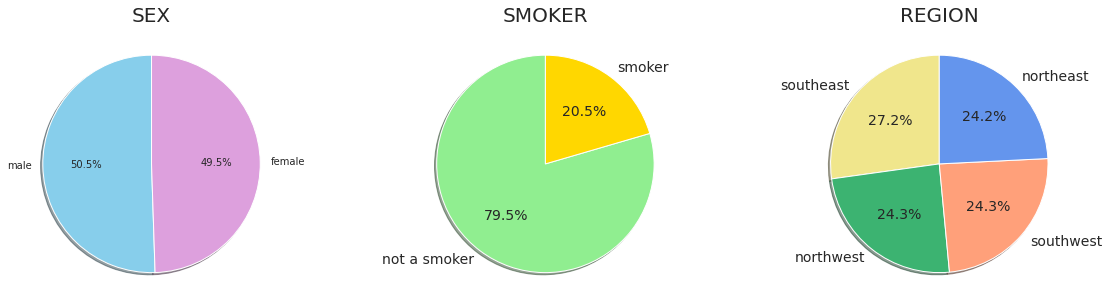

In [0]:
female_male = pd.DataFrame(data_insurance['sex'].value_counts(normalize=True))
smoker_an_not = pd.DataFrame(data_insurance['smoker'].value_counts(normalize=True))
regions = pd.DataFrame(data_insurance['region'].value_counts(normalize=True))

label_2 = ['not a smoker','smoker']
label_1 = ['male','female']
fracs_1 = np.array(female_male.sex)
fracs_2 = np.array(smoker_an_not.smoker)
label_3 = ['southeast','northwest','southwest','northeast']
fracs_3 = np.array(regions.region)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5));

bplot1 = axes[0].pie(fracs_1,labels=label_1,
                autopct='%1.1f%%', shadow=True, startangle=90, colors = ['skyblue','plum']) ; 
axes[0].set_title('SEX',fontsize = 20);

bplot2 = axes[1].pie(fracs_2,labels=label_2,
                autopct='%1.1f%%', shadow=True, startangle=90 , colors = ['lightgreen','gold'], textprops={'fontsize': 14})  ;
axes[1].set_title('SMOKER',fontsize = 20);

bplot3 = axes[2].pie(fracs_3,labels=label_3,
                autopct='%1.1f%%', shadow=True, startangle=90 , colors = ['khaki','mediumseagreen','lightsalmon','cornflowerblue'], textprops={'fontsize': 14});  
axes[2].set_title('REGION',fontsize = 20);

for ax in axes:
    ax.yaxis.grid(True)

plt.show()

Представлена информация о страховых взносах как мужчин, так и женщин *(при этом практически равное количество записей для каждого пола)*.

Большее количество клиентов являются некурящими *(79,5%)*.

По регионам клиенты распределены приблизительно равномерно *(больше записей по SH региону - 27,2%)*

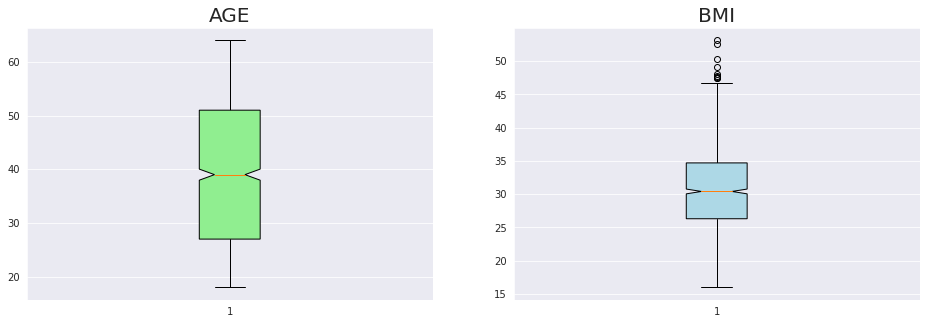

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

bplot1 = axes[0].boxplot(data_insurance.age,
                         boxprops=dict(facecolor='lightgreen', color='black'),
                         notch=True,
                         vert=True,  
                         patch_artist=True)  
axes[0].set_title('AGE',fontsize = 20)

bplot2 = axes[1].boxplot(data_insurance.bmi,
                         boxprops=dict(facecolor='lightblue', color='black'),
                         notch=True,
                         vert=True,  
                         patch_artist=True) 
axes[1].set_title('BMI',fontsize = 20)

for ax in axes:
    ax.yaxis.grid(True)

plt.show()

Возраст колеблется от 18 до 64 лет. Средний возраст - 40 лет.

Индекс массы тела распределен следующим образом: min - 15.96, max - 53.13, mean - 30.66.

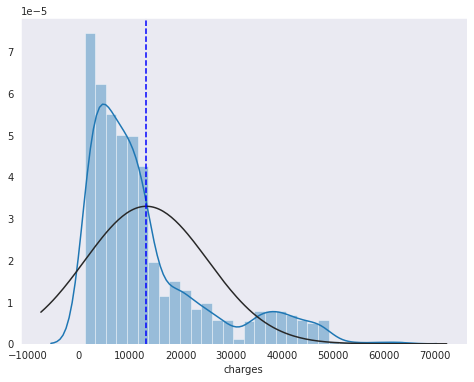

In [0]:
plt.figure(figsize=(8,6))
sns.distplot(data_insurance['charges'], fit=norm);
plt.axvline(data_insurance['charges'].mean(), linestyle = '--', color = 'b');

На графике выше видим распредление размера страховых выплат по датасету. Далее рассмотрим это распределение в разрезе различных категорий.

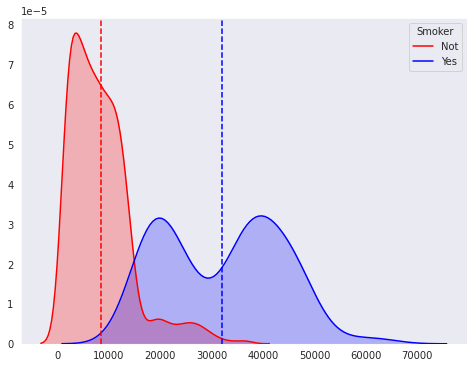

In [0]:
plt.figure(figsize=(8,6))
target_1 = data_insurance['charges'].loc[data_insurance['smoker'] == 'no']
target_2 = data_insurance['charges'].loc[data_insurance['smoker'] == 'yes']
sns.kdeplot(target_1,color ='r', shade=True)
sns.kdeplot(target_2,color = 'b', shade=True)
plt.legend(title='Smoker', loc='upper right', labels=['Not', 'Yes']);
plt.axvline(target_1.mean(), linestyle = '--', color = 'r');
plt.axvline(target_2.mean(), linestyle = '--', color = 'b');

Курящие люди вынуждены платить приблизительно в 3 раза больше за страхование.

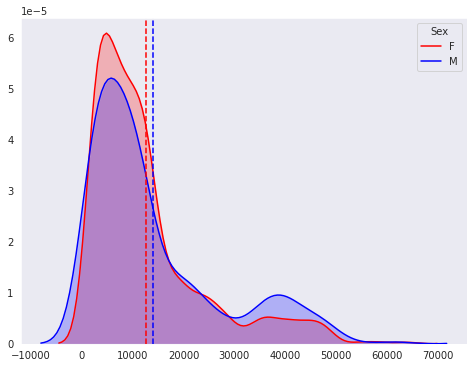

In [0]:
plt.figure(figsize=(8,6))
target_1 = data_insurance['charges'].loc[data_insurance['sex'] == 'female']
target_2 = data_insurance['charges'].loc[data_insurance['sex'] == 'male']
sns.kdeplot(target_1,color ='r', shade=True)
sns.kdeplot(target_2,color = 'b', shade=True)
plt.legend(title='Sex', loc='upper right', labels=['F', 'M']);
plt.axvline(target_1.mean(), linestyle = '--', color = 'r');
plt.axvline(target_2.mean(), linestyle = '--', color = 'b');

В среднем мужчины платят больше страховых взносов, чем женщины.

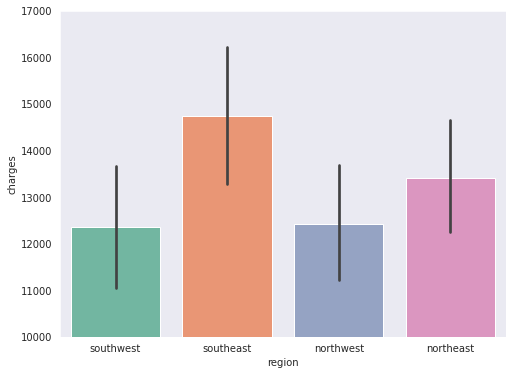

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(data_insurance['region'],data_insurance['charges'], palette='Set2');
plt.ylim(10000,17000);

Максимальные страховые взносы соответствуют SH региону.

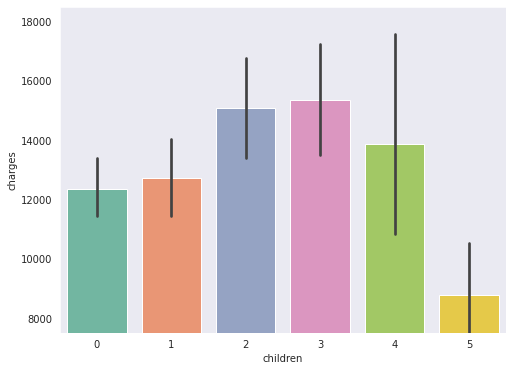

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(data_insurance['children'],data_insurance['charges'], palette='Set2');
plt.ylim(7500,18500);

Средние взносы максимальны у людей, которые имеют 2 или 3 ребенка, а минимальны у воспитывающих 5-рых. Наибольший разброс по искомой величине у клиентов с 4-мя детьми.

In [0]:
data_insurance.sex = data_insurance.sex.map({'female': 1 , 'male' : 0})
data_insurance.smoker = data_insurance.smoker.map({'yes': 1 , 'no' : 0})

Для представления категориальных признаков используем OneHotEncoder кодирование.

In [0]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit_transform(data_insurance.region.values.reshape(-1, 1)).toarray()
column_names = np.array(ohe.get_feature_names(['region']))
region_ohe = pd.DataFrame(ohe.fit_transform(data_insurance.region.values.reshape(-1, 1)).toarray(),columns=column_names)
data_insurance.pop('region')
column_names = list(data_insurance.columns.append(region_ohe.columns))
data_insurance = pd.concat([data_insurance, region_ohe], ignore_index=True, axis=1)
data_insurance.columns = column_names


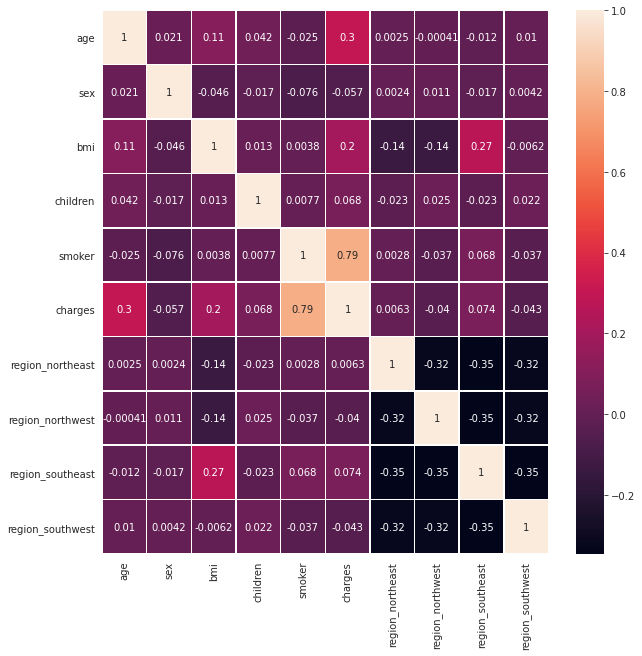

In [0]:
corr_data_insurance = data_insurance.corr()
plt.figure(figsize=(10,10))
heat_map = sns.heatmap(corr_data_insurance,annot=True, linewidths=.5);
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0);

Исходя из данной визуализации, можно заметить сильную зависимость(0,79) между размером страховых взносов и курением. Также взносы имеют зависимость от возраста и ИМТ.

## Data Split

Разделим данные для дальнейшего построения моделей на тестовую и обучающую выборку. Разделение производися как 3/7.

In [0]:
y = data_insurance.pop('charges')
X = data_insurance.copy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## UMAP

Проанализируем данные c помощью алгоритма снижения размерности данных UMAP. Возможно, увидим четкие кластеры данных. Предсказывая страховые выплаты в каждом, можно повысить точность.

In [0]:
X_2_comp = umap.UMAP().fit_transform(data_insurance)

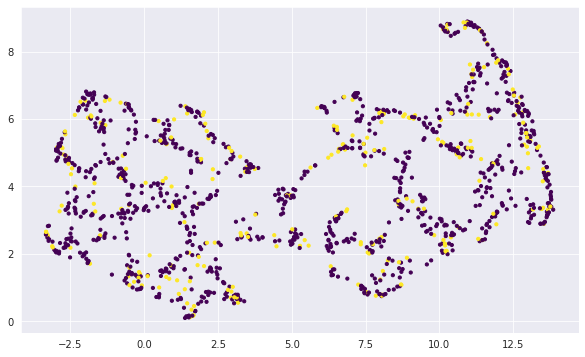

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance.smoker, s=10, cmap='viridis')
plt.grid()

Не видим четких кластеров (данные в разрезе курящих/некурящих).

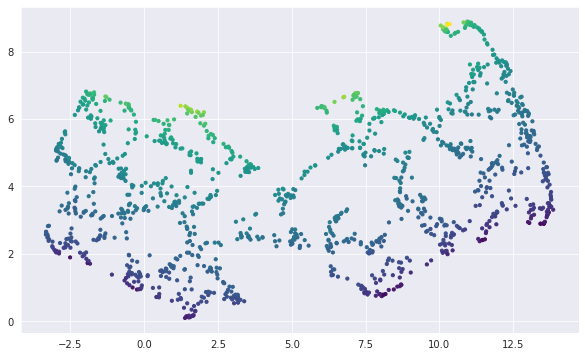

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance.bmi, s=10, cmap='viridis')
plt.grid()

Четких кластеров нет, но зависимость размера выплат от ИМТ видим.

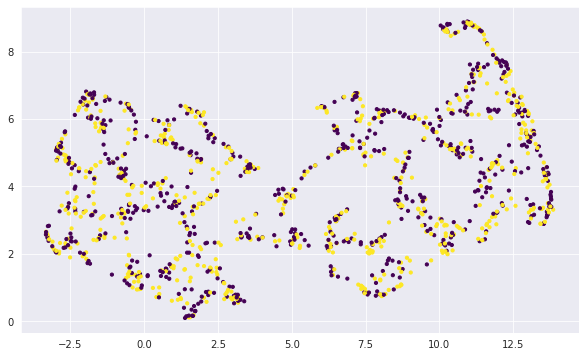

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance.sex, s=10, cmap='viridis')
plt.grid()

Четких кластеров и зависимости не наблюдаем при рассмотрении в разрезе пола.

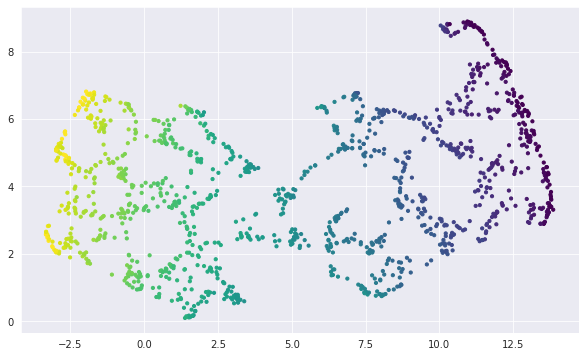

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance.age, s=10, cmap='viridis')
plt.grid()

Четких кластеров нет, но зависимость размера выплат от возраста видим.

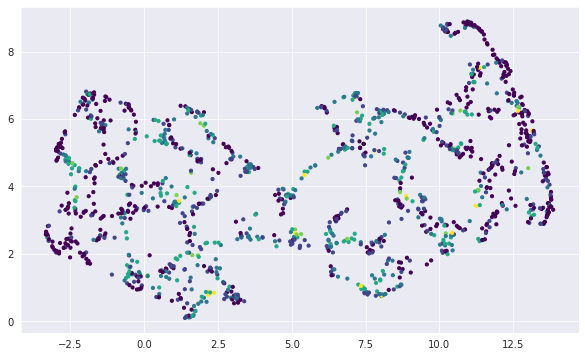

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance.children, s=10, cmap='viridis')
plt.grid()

Рассматривая данные в разрезе количества детей, не наблюдаем кластеров и зависимостей.

In [0]:
data_insurance_const.region = data_insurance_const.region.map({'southeast': 1 , 'northeast' : 2,'southwest': 3 , 'northwest' : 4})

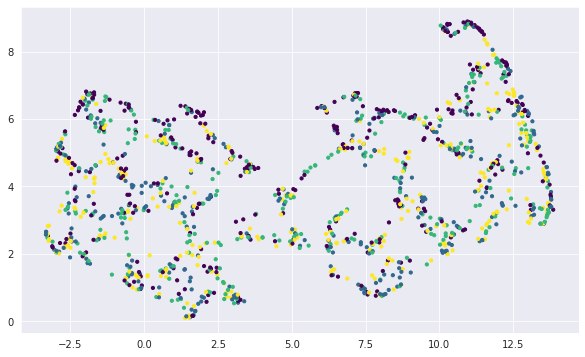

In [0]:
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.scatter(x=X_2_comp[:, 0], y=X_2_comp[:, 1],c = data_insurance_const.region, s=10, cmap='viridis')
plt.grid()

Рассматривая по регионам, не видим зависимости.

Таким образом, в силу небольшого размера данных и анализа, производившегося выше, будем использовать полные данные для моделей.

# Models

Проанализируем несколько моделей, чтобы в дальнейшем выбрать наиболее перспективную.

В каждой моделе будем производить настройку и поиск оптимальных параметров, использовать кроссвалидацию.

Для оценки качества моделей используем: MAE, MSE, RMSE, R2-score. Также проанализируем врямя работы моделей.

В результате получили, что наиболее важными признаками являются: smoker, bmi, age.

Исходя из графиков зависимости предсказанной и фактической еличиной страховых выплат, видим положительный тренд, что свидетельствует о том, что модели построены хорошо.

## Linear Regression

In [0]:
regressor = LinearRegression()  

In [0]:
%%time
regressor.fit(X_train, y_train)

CPU times: user 4.6 ms, sys: 0 ns, total: 4.6 ms
Wall time: 4.2 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
print(regressor.intercept_)
print(regressor.coef_)

-12471.881128595147
[  256.43544682    47.54675517   335.36907276   472.70978916
 23435.99116948   589.02469054    27.12354518  -405.723989
  -210.42424672]


In [0]:
y_pred = regressor.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 4011.449679327985
MSE: 33342497.826954577
RMSE: 5774.296305780867
R2 score: 0.7909160991789905


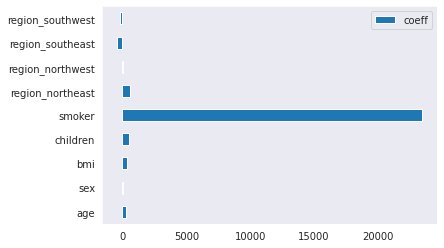

In [0]:
coef = pd.DataFrame({'coeff': regressor.coef_}, index = X_test.columns)
coef.plot.barh();

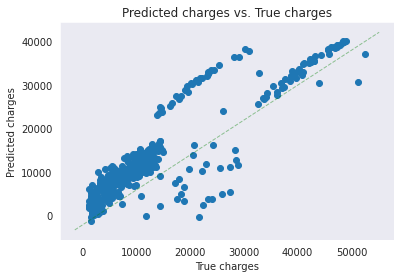

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'lin_reg')

## Random Forest


In [0]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [0]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1200}

In [0]:
rf = RandomForestRegressor(bootstrap = True, max_depth= 50, max_features='auto',min_samples_leaf= 4 , min_samples_split=10, n_estimators=1200)

In [0]:
%%time
rf.fit(X_train, y_train)

CPU times: user 2.64 s, sys: 11.7 ms, total: 2.65 s
Wall time: 2.65 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = rf.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 2542.072918310145
MSE: 18203813.649543654
RMSE: 4266.592744748865
R2 score: 0.8858476534236017


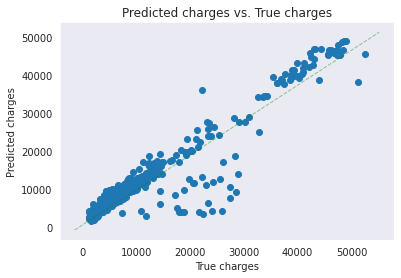

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

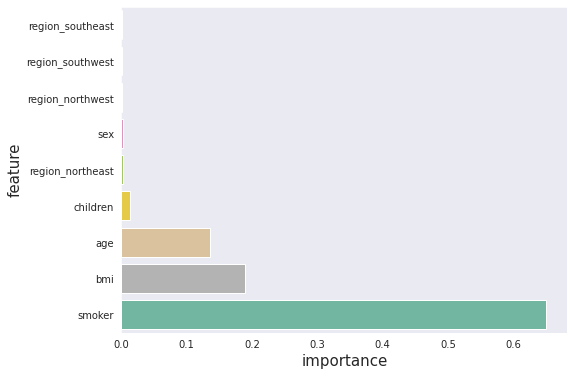

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(y='a', x='b', data=pd.DataFrame({'a': X.columns.astype(str), 'b': rf.feature_importances_}).sort_values(by='b'), orient='h', palette="Set2");
plt.xlabel('importance', fontsize = 15);
plt.ylabel('feature', fontsize = 15);

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'rf')

## Gradient Boosting

In [0]:
random_grid = {'n_estimators': [200,300,500,700,1000,1500],
               'max_depth' : [4,5,6,7,8,9,10,20],
               'min_samples_split': [2,4,5,7,9],
               'learning_rate': [0.03,0.01,0.1,0.3,0.5]
                 }
print(random_grid)

{'n_estimators': [200, 300, 500, 700, 1000, 1500], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 20], 'min_samples_split': [2, 4, 5, 7, 9], 'learning_rate': [0.03, 0.01, 0.1, 0.3, 0.5]}


In [0]:
gb_reg = GradientBoostingRegressor()
gb_reg_random = RandomizedSearchCV(estimator = gb_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gb_reg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [0]:
gb_reg_random.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'min_samples_split': 2,
 'n_estimators': 700}

In [0]:
gb_reg = GradientBoostingRegressor(max_depth = 4, n_estimators= 700, learning_rate=0.1, min_samples_split = 2)

In [0]:
%%time
gb_reg.fit(X_train, y_train)

CPU times: user 836 ms, sys: 2.71 ms, total: 838 ms
Wall time: 845 ms


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=700,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
y_pred = gb_reg.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 3287.825111088089
MSE: 30131634.754229028
RMSE: 5489.228976297949
R2 score: 0.8110507567481924


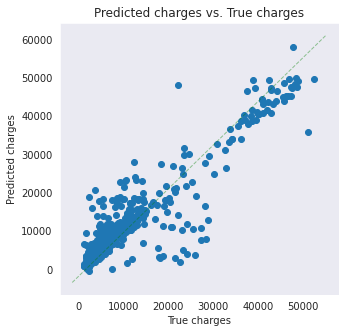

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

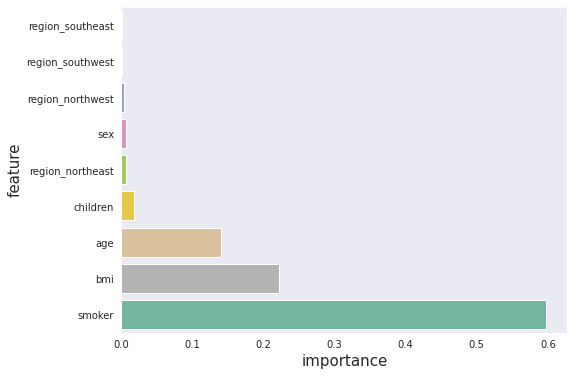

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(y='a', x='b', data=pd.DataFrame({'a': X.columns.astype(str), 'b': gb_reg.feature_importances_}).sort_values(by='b'), orient='h', palette="Set2");
plt.xlabel('importance', fontsize = 15);
plt.ylabel('feature', fontsize = 15);

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'gb')

## CatBoost

In [0]:
random_grid = {'depth': [4,5,6,7,8,9,10,20],
               'learning_rate' : [0.03,0.01,0.1,0.3,0.5],
               'iterations': [10,30,50,100,150,1000]
                 }
print(random_grid)


{'depth': [4, 5, 6, 7, 8, 9, 10, 20], 'learning_rate': [0.03, 0.01, 0.1, 0.3, 0.5], 'iterations': [10, 30, 50, 100, 150, 1000]}


In [0]:
cat_reg = CatBoostRegressor()
cat_reg_random = RandomizedSearchCV(estimator = cat_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
cat_reg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   57.4s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	learn: 10998.0784046	total: 47.1ms	remaining: 2.31s
1:	learn: 10296.8518852	total: 48.1ms	remaining: 1.15s
2:	learn: 9581.0157464	total: 48.8ms	remaining: 764ms
3:	learn: 8944.8580797	total: 49.5ms	remaining: 569ms
4:	learn: 8421.4816844	total: 50.1ms	remaining: 451ms
5:	learn: 7925.3127755	total: 50.7ms	remaining: 372ms
6:	learn: 7461.7180832	total: 51.3ms	remaining: 315ms
7:	learn: 7056.9894436	total: 51.9ms	remaining: 272ms
8:	learn: 6713.1608346	total: 52.5ms	remaining: 239ms
9:	learn: 6439.4296483	total: 53.2ms	remaining: 213ms
10:	learn: 6189.6484257	total: 53.8ms	remaining: 191ms
11:	learn: 5965.9801010	total: 54.5ms	remaining: 173ms
12:	learn: 5787.3603628	total: 55.1ms	remaining: 157ms
13:	learn: 5617.9807025	total: 55.8ms	remaining: 144ms
14:	learn: 5477.2596165	total: 56.5ms	remaining: 132ms
15:	learn: 5363.7966424	total: 57.1ms	remaining: 121ms
16:	learn: 5241.8162073	total: 57.7ms	remaining: 112ms
17:	learn: 5180.7663526	total: 58ms	remaining: 103ms
18:	learn: 5079.8600

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f8fb76d86a0>,
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [4, 5, 6, 7, 8, 9, 10, 20],
                                        'iterations': [10, 30, 50, 100, 150,
                                                       1000],
                                        'learning_rate': [0.03, 0.01, 0.1, 0.3,
                                                          0.5]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [0]:
cat_reg_random.best_params_

{'depth': 5, 'iterations': 50, 'learning_rate': 0.1}

In [0]:
cat_reg = CatBoostRegressor(depth = 5, iterations= 50, learning_rate=0.1)

In [0]:
%%time
cat_reg.fit(X_train, y_train)

0:	learn: 10998.0784046	total: 1.34ms	remaining: 65.5ms
1:	learn: 10296.8518852	total: 2.27ms	remaining: 54.4ms
2:	learn: 9581.0157464	total: 2.97ms	remaining: 46.5ms
3:	learn: 8944.8580797	total: 3.65ms	remaining: 42ms
4:	learn: 8421.4816844	total: 4.33ms	remaining: 39ms
5:	learn: 7925.3127755	total: 4.86ms	remaining: 35.6ms
6:	learn: 7461.7180832	total: 5.5ms	remaining: 33.8ms
7:	learn: 7056.9894436	total: 6.01ms	remaining: 31.5ms
8:	learn: 6713.1608346	total: 6.63ms	remaining: 30.2ms
9:	learn: 6439.4296483	total: 7.35ms	remaining: 29.4ms
10:	learn: 6189.6484257	total: 8.01ms	remaining: 28.4ms
11:	learn: 5965.9801010	total: 8.62ms	remaining: 27.3ms
12:	learn: 5787.3603628	total: 9.22ms	remaining: 26.2ms
13:	learn: 5617.9807025	total: 9.85ms	remaining: 25.3ms
14:	learn: 5477.2596165	total: 10.5ms	remaining: 24.6ms
15:	learn: 5363.7966424	total: 11.2ms	remaining: 23.8ms
16:	learn: 5241.8162073	total: 11.8ms	remaining: 23ms
17:	learn: 5180.7663526	total: 12.2ms	remaining: 21.7ms
18:	lea

In [0]:
y_pred = cat_reg.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 2460.0472368782684
MSE: 16916188.852783654
RMSE: 4112.929473353956
R2 score: 0.8939220819411556


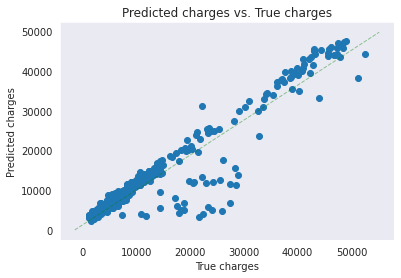

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

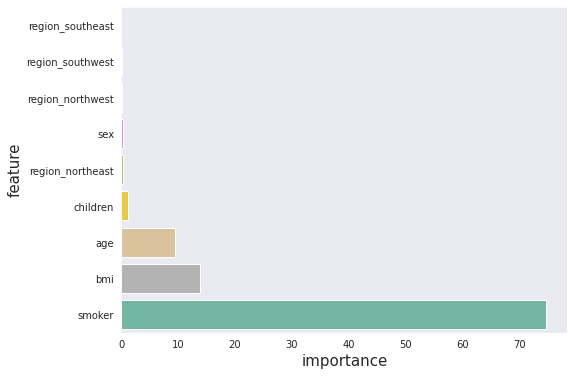

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(y='a', x='b', data=pd.DataFrame({'a': X.columns.astype(str), 'b': cat_reg.get_feature_importance()}).sort_values(by='b'), orient='h', palette="Set2");
plt.xlabel('importance', fontsize = 15);
plt.ylabel('feature', fontsize = 15);

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'cat_boost')

## XGBoost

In [0]:
random_grid = {'n_estimators': [200, 400, 600, 800, 1000],
               'max_depth': [6, 8, 10, 15,20],
               'reg_lambda': [0,0.1,0.5, 1, 2]}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [6, 8, 10, 15, 20], 'reg_lambda': [0, 0.1, 0.5, 1, 2]}


In [0]:
xgb_reg = XGBRegressor()
xgb_reg_random = RandomizedSearchCV(estimator = xgb_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xgb_reg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min


[08:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                          seed=None, silent=None, subsample=1,
                                  

In [0]:
xgb_reg_random.best_params_

{'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 1}

In [0]:
xgb_reg = XGBRegressor(max_depth = 6, n_estimators= 200, reg_lambda=1)

In [0]:
%%time
xgb_reg.fit(X_train, y_train)

[11:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 181 ms, sys: 5.84 ms, total: 187 ms
Wall time: 188 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xgb_reg.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 3053.460444124825
MSE: 26865473.035213266
RMSE: 5183.191394808151
R2 score: 0.8315321806795453


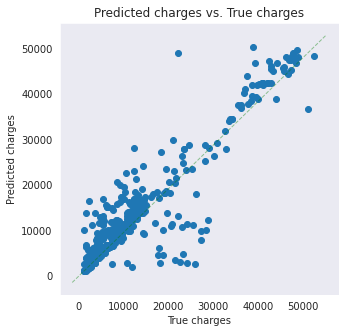

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

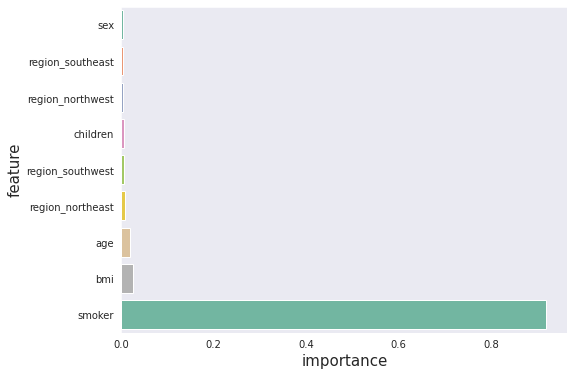

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(y='a', x='b', data=pd.DataFrame({'a': X.columns.astype(str), 'b': xgb_reg.feature_importances_}).sort_values(by='b'), orient='h', palette="Set2");
plt.xlabel('importance', fontsize = 15);
plt.ylabel('feature', fontsize = 15);

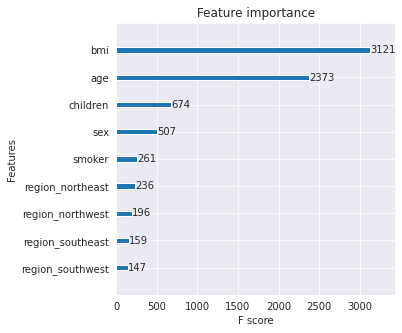

In [0]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'xgboost')

## LightGBM 

In [0]:
random_grid = {'n_estimators': [200, 400, 600, 800, 1000],
               'max_depth': [6, 8, 10, 15,20],
               'learning_rate': [0.005, 0.001, 0.01, 0.5, 1],
               'max_depth': [6, 8, 10, 15,20],
               "num_iterations": [100, 1000, 10000,100000]}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [6, 8, 10, 15, 20], 'learning_rate': [0.005, 0.001, 0.01, 0.5, 1], 'num_iterations': [100, 1000, 10000, 100000]}


In [0]:
lgbm_reg = lgb.LGBMRegressor()
lgbm_reg_random = RandomizedSearchCV(estimator = lgbm_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
lgbm_reg_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.0min finished
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=None,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silen...,
                                           subsample_for_bin=200000,
                                           subsample_freq=0),
    

In [0]:
lgbm_reg_random.best_params_

{'learning_rate': 0.005,
 'max_depth': 6,
 'n_estimators': 600,
 'num_iterations': 1000}

In [0]:
lgbm_reg = lgb.LGBMRegressor(max_depth = 6, n_estimators= 600, learning_rate=0.005,num_iterations = 1000)

In [0]:
%%time
lgbm_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 407 ms, sys: 33.1 ms, total: 440 ms
Wall time: 442 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.005, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_iterations=1000, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
y_pred = lgbm_reg.predict(X_test)

In [0]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print ('R2 score:', metrics.r2_score(y_test, y_pred))

MAE: 2546.8506654685157
MSE: 18186903.234909225
RMSE: 4264.610560755721
R2 score: 0.8859536951327327


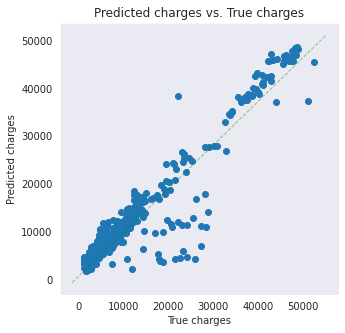

In [0]:
plt.scatter(y_test, y_pred)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [ymin, ymax], "g--", lw=1, alpha=0.4)
plt.xlabel("True charges")
plt.ylabel("Predicted charges")
plt.title('Predicted charges vs. True charges')
plt.show()

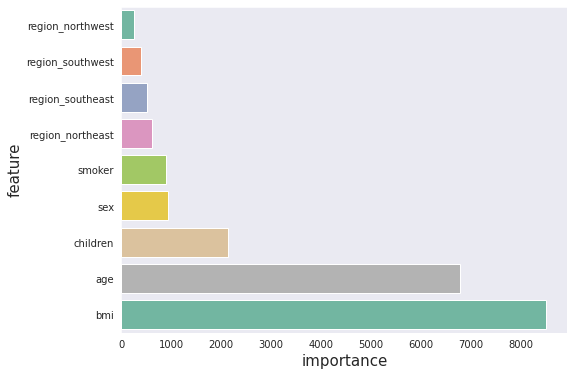

In [0]:
plt.figure(figsize=(8,6))
sns.barplot(y='a', x='b', data=pd.DataFrame({'a': X.columns.astype(str), 'b': lgbm_reg.feature_importances_}).sort_values(by='b'), orient='h', palette="Set2");
plt.xlabel('importance', fontsize = 15);
plt.ylabel('feature', fontsize = 15);

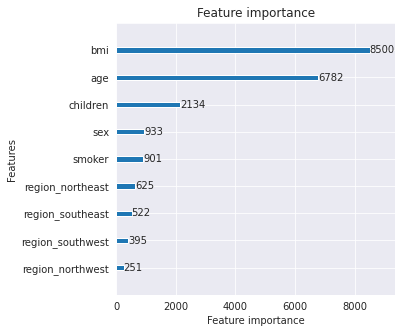

In [0]:
lgb.plot_importance(lgbm_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [0]:
mae = np.append(mae, metrics.mean_absolute_error(y_test, y_pred))
mse = np.append(mse, metrics.mean_squared_error(y_test, y_pred))
rmse = np.append(rmse, np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2 = np.append(r2, metrics.r2_score(y_test, y_pred))

In [0]:
indx = np.append(indx, 'lgbm')

# Results

Посмотрим на получившиеся результаты.

Из приведенных графиков видим, что *по метрикам качества* "выигрывает" модель **CatBost**.

Исходя из *времени выполнения*, наилучшим образом себя проявила **линейная регрессия**, но в остальном результаты по этой модели желают лучшего.

**CatBoost** имеет также малое время выполнение, что делает его "лидером" среди представленых моделей. 

In [0]:
results = pd.DataFrame({'mae':mae, 'mse':mse, 'rmse':rmse, 'r2':r2}, index = indx)

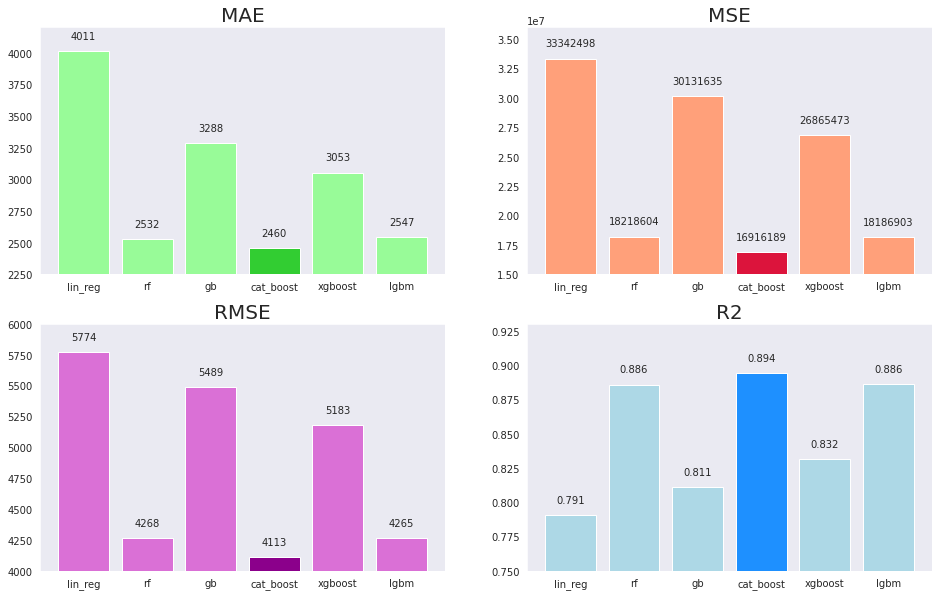

In [0]:
gridsize = (2, 2)
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))
 
my_colors = ['palegreen','palegreen','palegreen','limegreen' , 'palegreen','palegreen']
ax1.bar(results.index, results['mae'],color = my_colors)
ax1.set_title("MAE", fontsize  = 20)
ax1.set_ylim(2250,4200)
for p in ax1.patches:
  ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points')

my_colors = ['lightsalmon','lightsalmon','lightsalmon','crimson', 'lightsalmon','lightsalmon'] 
ax2.bar(results.index,results['mse'],color = my_colors)
ax2.set_title("MSE", fontsize  = 20)
ax2.set_ylim(15000000,36000000)
for p in ax2.patches:
  ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points')

my_colors = ['orchid','orchid','orchid','darkmagenta', 'orchid','orchid']
ax3.bar(results.index, results['rmse'],color = my_colors)
ax3.set_title("RMSE", fontsize  = 20)
ax3.set_ylim(4000,6000)
for p in ax3.patches:
  ax3.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points')

my_colors = ['lightblue','lightblue','lightblue', 'dodgerblue', 'lightblue','lightblue']
ax4.bar(results.index, results['r2'], color = my_colors)
ax4.set_title("R2", fontsize  = 20)
ax4.set_ylim(0.75,0.93)
for p in ax4.patches:
  ax4.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points')
      

 
plt.show()

In [0]:
list_time = [4.2,2650,845,74.8,188,442]
res_time = pd.DataFrame({'time(ms)':list_time}, index=indx)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  import sys


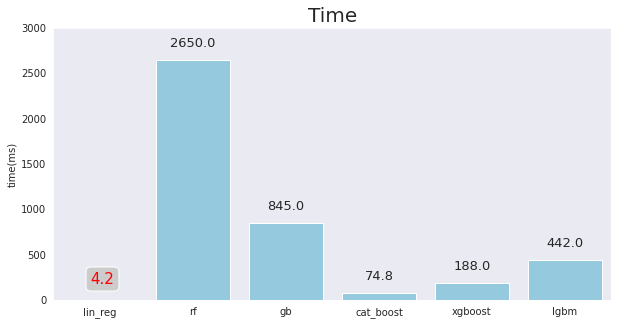

In [0]:
plt.figure(figsize=(10,5))
ax = sns.barplot(results.index, res_time['time(ms)'],color = 'skyblue');
ax.set_title("Time", fontsize  = 20)
ax.set_ylim(0,3000)
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.1f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', xytext = (0, 10), textcoords = 'offset points', fontsize  = 13)
ax.annotate('4.2', xy=(-0.1,15), textcoords = 'offset points', fontsize  = 15 , color = 'red',bbox=dict(boxstyle="round", fc="0.8"))

plt.show()